In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

Hoy analizaremos un dataset sobre los fallecimientos por COVID-19 en Peru utilizando la plataforma nacional de datos abiertos emitido por el ministerio de Salud  - MINSA. Contamos con datos sobre la edad, sexo, departamento, provincia, distrito y clasificacion de criterios clinicos

In [2]:
covidpe = pd.read_csv("fallecidos_covid.csv", sep=';')

C:\Users\User\AppData\Local\Temp\ipykernel_24568\3301934751.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  covidpe = pd.read_csv("fallecidos_covid.csv", sep=';')


In [3]:
covidpe.head(5)

,FECHA_CORTE,FECHA_FALLECIMIENTO,EDAD_DECLARADA,SEXO,CLASIFICACION_DEF,DEPARTAMENTO,PROVINCIA,DISTRITO,UBIGEO,id_persona
0,20231114,20210611,21,MASCULINO,SINADEF,LAMBAYEQUE,CHICLAYO,CHICLAYO,140101,24833991.0
1,20231114,20210317,45,MASCULINO,serologico,PIURA,SULLANA,SULLANA,200601,24761117.0
2,20231114,20210602,62,FEMENINO,virologico,ICA,PISCO,SAN CLEMENTE,110507,24767070.0
3,20231114,20210703,75,MASCULINO,virologico,AREQUIPA,AREQUIPA,MIRAFLORES,40110,24751741.0
4,20231114,20210506,66,FEMENINO,virologico,LIMA,LIMA,SAN JUAN DE LURIGANCHO,150132,24671820.0


In [4]:
covidpe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201902 entries, 0 to 201901
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   FECHA_CORTE          201902 non-null  int64  
 1   FECHA_FALLECIMIENTO  201902 non-null  int64  
 2   EDAD_DECLARADA       201902 non-null  int64  
 3   SEXO                 201902 non-null  object 
 4   CLASIFICACION_DEF    201902 non-null  object 
 5   DEPARTAMENTO         201902 non-null  object 
 6   PROVINCIA            201897 non-null  object 
 7   DISTRITO             201897 non-null  object 
 8   UBIGEO               201902 non-null  object 
 9   id_persona           198512 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 15.4+ MB


Al parecer tenemos valores nulos en las columnas de Provincia, Distrito e id_persona asi que manos a la obra 

In [5]:
covidpe.isnull().sum()

FECHA_CORTE               0
FECHA_FALLECIMIENTO       0
EDAD_DECLARADA            0
SEXO                      0
CLASIFICACION_DEF         0
DEPARTAMENTO              0
PROVINCIA                 5
DISTRITO                  5
UBIGEO                    0
id_persona             3390
dtype: int64

Vaya tenemos muchos valores nulos para id_persona, dado que cada id es un registro de fallecimiento creare una nueva columna y luego la remplazaremos por los nuevos id por cada fila

In [6]:
covidpe['persona_ID'] = range(1, len(covidpe) + 1)

In [7]:
covidpe.drop('id_persona', axis=1, inplace=True)

Ahora empecemos con los valores nulos en provincia y distrito, primero identificamos los indices de esos NaN

In [8]:
valores_nan = covidpe[covidpe['PROVINCIA'].isna()]

print("Valores NaN en 'PROVINCIA':")
print(valores_nan)

Valores NaN en 'PROVINCIA':
        FECHA_CORTE  FECHA_FALLECIMIENTO  EDAD_DECLARADA       SEXO  \
6433       20231114             20200419              76   FEMENINO   
57361      20231114             20200424              48  MASCULINO   
134092     20231114             20200414              80   FEMENINO   
199415     20231114             20200515              83   FEMENINO   
200742     20231114             20200426              74  MASCULINO   

       CLASIFICACION_DEF DEPARTAMENTO PROVINCIA DISTRITO UBIGEO  persona_ID  
6433             clinico   LAMBAYEQUE       NaN      NaN      .        6434  
57361            clinico       CALLAO       NaN      NaN      .       57362  
134092           clinico       LORETO       NaN      NaN      .      134093  
199415           clinico   SAN MARTIN       NaN      NaN      .      199416  
200742           clinico   LAMBAYEQUE       NaN      NaN      .      200743  


Aunque los datos nulos no representen una cantidad signficativa del dataframe vamos a darle un tratamiento asi que empezamos obteniendo la moda para remplazar esos valores

In [9]:
moda_por_distrito = covidpe.groupby('DEPARTAMENTO')['DISTRITO'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()

In [10]:
moda_por_provincia = covidpe.groupby('DEPARTAMENTO')['PROVINCIA'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()

In [11]:
cambios = {
    6433: ('CHICLAYO', 'CHICLAYO'),
    57361: ('CALLAO', 'CALLAO'),
    134092: ('MAYNAS', 'IQUITOS'),
    199415: ('SAN MARTIN', 'TARAPOTO'),
    200742: ('CHICLAYO', 'CHICLAYO')
}

for indice, (prov, dist) in cambios.items():
    covidpe.at[indice, 'PROVINCIA'] = prov
    covidpe.at[indice, 'DISTRITO'] = dist

In [12]:
covidpe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201902 entries, 0 to 201901
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   FECHA_CORTE          201902 non-null  int64 
 1   FECHA_FALLECIMIENTO  201902 non-null  int64 
 2   EDAD_DECLARADA       201902 non-null  int64 
 3   SEXO                 201902 non-null  object
 4   CLASIFICACION_DEF    201902 non-null  object
 5   DEPARTAMENTO         201902 non-null  object
 6   PROVINCIA            201902 non-null  object
 7   DISTRITO             201902 non-null  object
 8   UBIGEO               201902 non-null  object
 9   persona_ID           201902 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 15.4+ MB


Genial, ahora si no tenemos valores nulos :)

In [13]:
covidpe.describe()

,FECHA_CORTE,FECHA_FALLECIMIENTO,EDAD_DECLARADA,persona_ID
count,201902.0,2.019020e+05,201902.000000,201902.000000
mean,20231114.0,2.020591e+07,66.049524,100951.500000
std,0.0,4.825318e+03,15.378123,58284.231362
min,20231114.0,2.020030e+07,-9.000000,1.000000
25%,20231114.0,2.020072e+07,57.000000,50476.250000
50%,20231114.0,2.021012e+07,67.000000,100951.500000
75%,20231114.0,2.021041e+07,77.000000,151426.750000
max,20231114.0,2.021121e+07,117.000000,201902.000000


Vaya esta un poco raro que una persona tenga -9 años, vemoslo mejor en un grafico, pero primero cambiemos algunos nombres de las columnas y eliminemos la columna de fecha_corte 

In [14]:
covidpe=covidpe.drop('FECHA_CORTE', axis=1)

In [15]:
covidpe.rename(columns={'EDAD_DECLARADA':'EDAD','CLASIFICACION_DEF':'CRITERIO'},inplace= True)

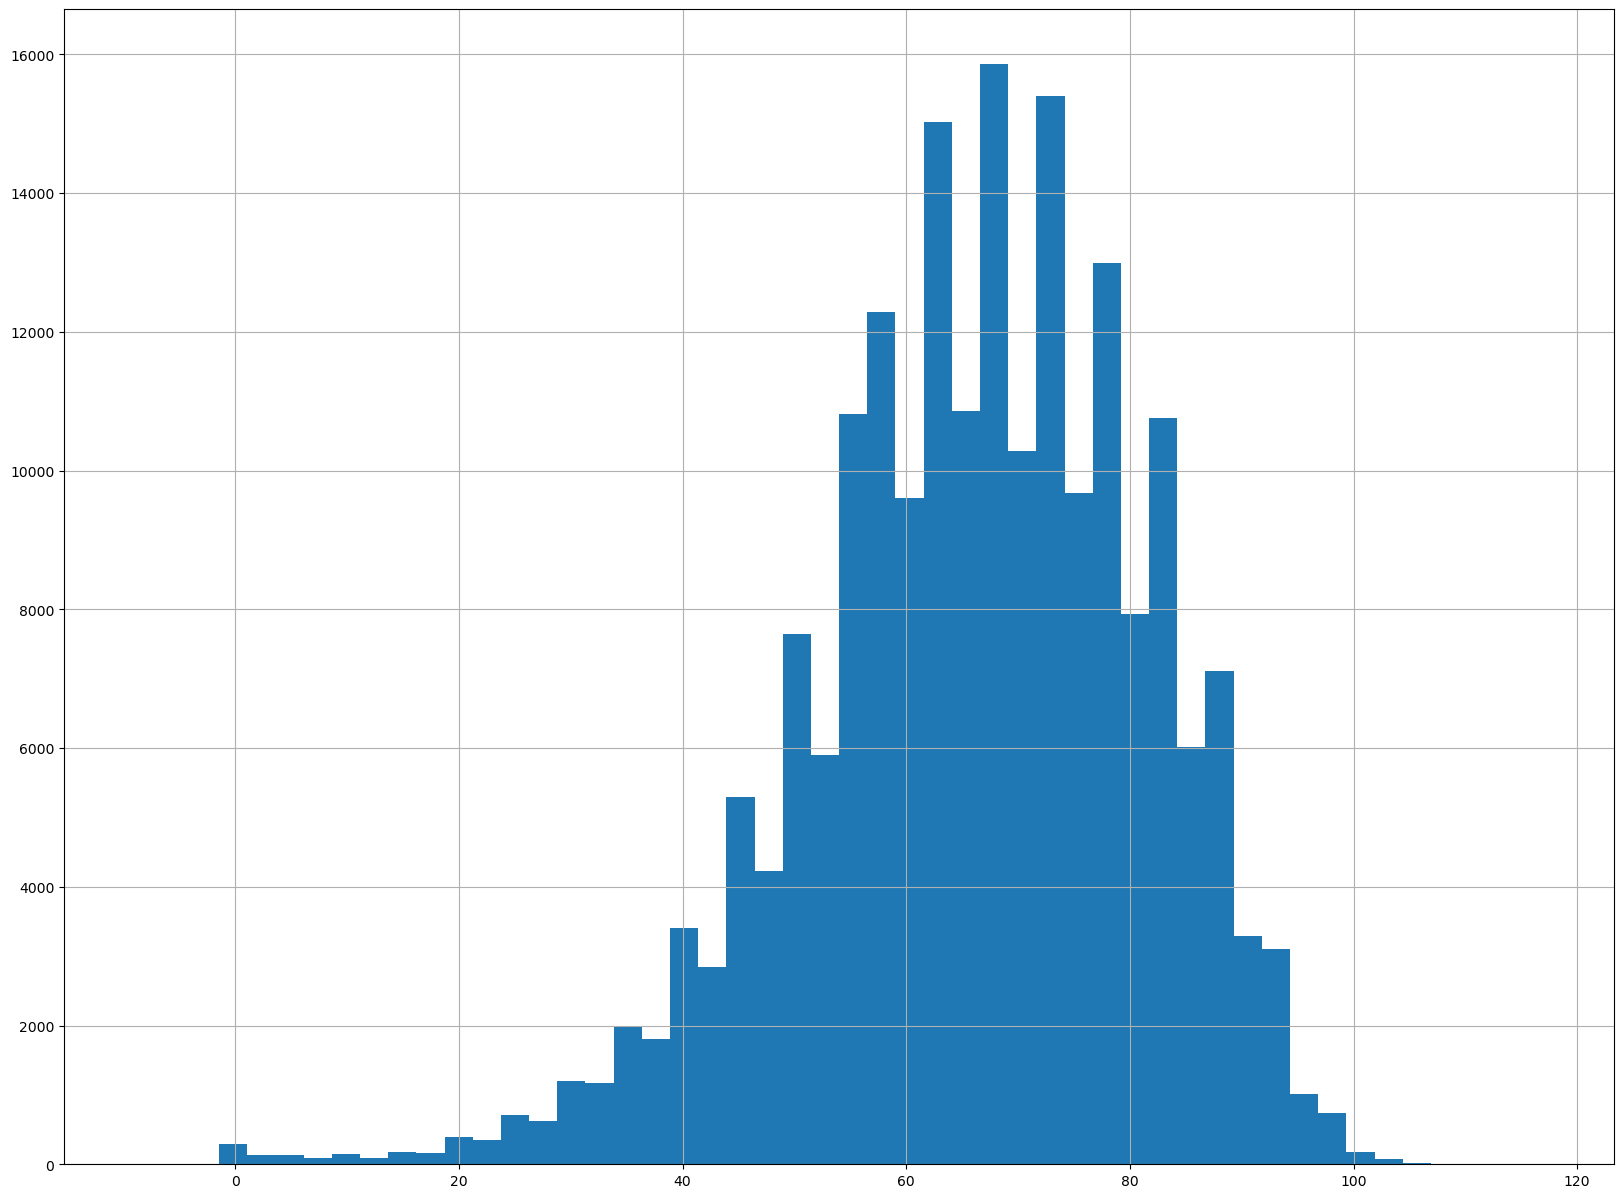

In [16]:
covidpe[('EDAD')].hist(bins = 50, figsize=(20,15))
plt.show()

Okeyy esto no me gusta, considerando que INEI manifiesta que los peruanos y las peruanas vivirán, en promedio, 74,6 años (72,0 años los hombres y 77,3 las mujeres) estas edades no son muy buenas. Veamos mas a fondo estos datos.

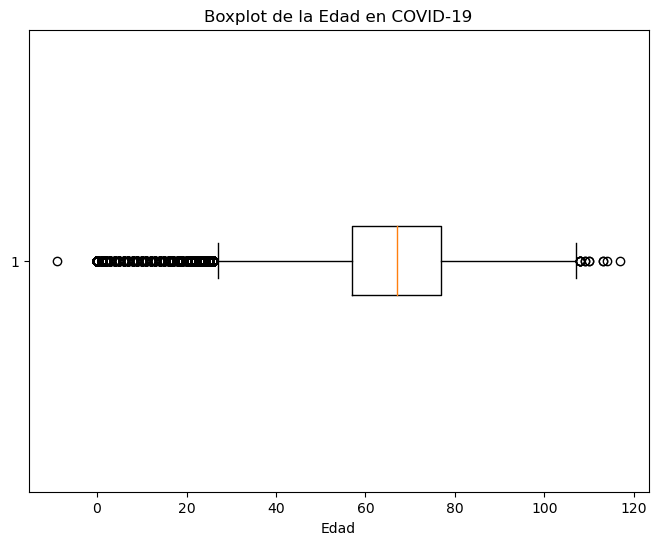

In [17]:
plt.figure(figsize=(8, 6))
plt.boxplot(covidpe['EDAD'], vert=False)
plt.title('Boxplot de la Edad en COVID-19')
plt.xlabel('Edad')
plt.show()

Como ya lo habiamos notado, tenemos outliers entre los 20  y 100 años de edad , asi que utilizare el Método de los 3 sigmas
 para definir nuestros limites superiores e inferiores

In [18]:
edades = covidpe['EDAD'].to_numpy()
promedio = np.mean(edades)
std = np.std(edades)

limite_superior = promedio + 3 * std
limite_inferior = promedio - 3 * std

print('Límite superior:', limite_superior)
print('Límite inferior:', limite_inferior)

covidpe_filtrado = covidpe[(covidpe['EDAD'] < limite_superior) & (covidpe['EDAD'] > limite_inferior)]

Límite superior: 112.18377745064751
Límite inferior: 19.91527060236831


Ahora si imputaremos esos outliers usando KNNImputer 

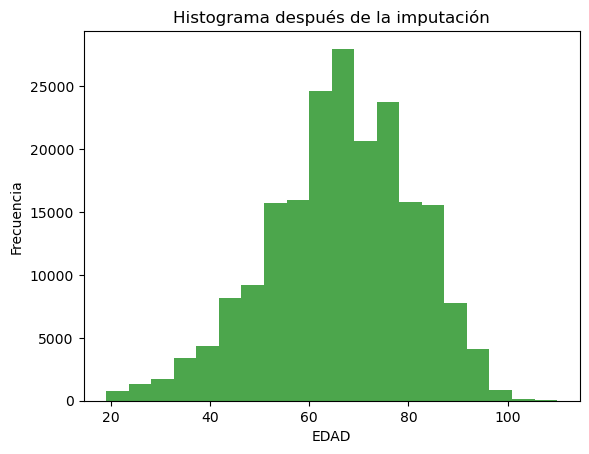

In [19]:
covidpe['EDAD'] = covidpe['EDAD'].apply(lambda x: x if 19 <= x <= 112 else None)

imputer = KNNImputer(n_neighbors=5)
covidpe['EDAD'] = imputer.fit_transform(covidpe[['EDAD']])

covidpe['EDAD'] = covidpe['EDAD'].astype(int)


plt.hist(covidpe['EDAD'], bins=20, color='green', alpha=0.7)
plt.title('Histograma después de la imputación')
plt.xlabel('EDAD')
plt.ylabel('Frecuencia')
plt.show()


In [20]:
covidpe.describe()

,FECHA_FALLECIMIENTO,EDAD,persona_ID
count,2.019020e+05,201902.000000,201902.000000
mean,2.020591e+07,66.409005,100951.500000
std,4.825318e+03,14.667814,58284.231362
min,2.020030e+07,19.000000,1.000000
25%,2.020072e+07,57.000000,50476.250000
50%,2.021012e+07,67.000000,100951.500000
75%,2.021041e+07,77.000000,151426.750000
max,2.021121e+07,110.000000,201902.000000


Bien ahora que hemos hecho la limpieza de datos ya podemos llevarlo a power BI para generar algunos graficos

In [21]:
covidpe.to_csv('covidpe_modificado.csv', index=False)
